# Call-a-Bike Destination Prediction

Based on data provided by the bike sharing scheme of Deutsche Bahn, goal of this little excercise is to predict the destination of customers based on the starting point, date, and time for the city of Hamburg.

The data covers a period of almost three and a half years, from January 1, 2014 to May 16, 2017.

## Preliminaries: load packages and data

In [1]:
import pandas as pd

from pandas.tseries.holiday import Holiday, AbstractHolidayCalendar, EasterMonday, GoodFriday, Easter
from pandas.tseries.offsets import Day, CustomBusinessDay

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import time

In [2]:

file = '../data/OPENDATA_BOOKING_CALL_A_BIKE.zip'

dateparser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

data = pd.read_csv(file, 
                   delimiter = ';',
                   compression = 'zip',
                   parse_dates = ['DATE_BOOKING', 'DATE_FROM', 'DATE_UNTIL'], 
                   #date_parser=dateparser, 
                   infer_datetime_format = True)

## Initial data wrangling

### Data quality checks and cleaning

what kind of columns and data types do we have?

In [3]:
print(data.dtypes)

BOOKING_HAL_ID                        int64
CATEGORY_HAL_ID                       int64
VEHICLE_HAL_ID                        int64
CUSTOMER_HAL_ID                      object
DATE_BOOKING                 datetime64[ns]
DATE_FROM                    datetime64[ns]
DATE_UNTIL                   datetime64[ns]
COMPUTE_EXTRA_BOOKING_FEE            object
TRAVERSE_USE                         object
DISTANCE                            float64
START_RENTAL_ZONE                    object
START_RENTAL_ZONE_HAL_ID            float64
END_RENTAL_ZONE                      object
END_RENTAL_ZONE_HAL_ID              float64
RENTAL_ZONE_HAL_SRC                  object
CITY_RENTAL_ZONE                     object
TECHNICAL_INCOME_CHANNEL             object
dtype: object


a brief look at the first few lines

In [4]:
data.head()

BOOKING_HAL_ID  CATEGORY_HAL_ID  VEHICLE_HAL_ID  \
0        21366843            51000          143517   
1        21367069            51000          119830   
2        21367072            51000          143501   
3        21367118            51000          117519   
4        21367155            51000          108641   

                            CUSTOMER_HAL_ID        DATE_BOOKING  \
0  A821059B555C7764A2FF801180874A2FCB326222 2014-01-01 00:34:54   
1  1EBC930DB407ACEAE2FDE23A6CA40492EA3DFBB2 2014-01-01 01:39:55   
2  7AD2C1B70137479062A6DD73815835986677BB2D 2014-01-01 01:40:20   
3  A1062EF019B4E3E71C551572F1B284D55440E3C4 2014-01-01 01:56:00   
4  4F4F752203EA6FC872D576E9289C4E1B362E16F6 2014-01-01 02:05:55   

            DATE_FROM          DATE_UNTIL COMPUTE_EXTRA_BOOKING_FEE  \
0 2014-01-01 00:34:54 2014-01-01 00:50:14                      Nein   
1 2014-01-01 01:39:55 2014-01-01 01:57:27                      Nein   
2 2014-01-01 01:40:20 2014-01-01 01:53:09                      Nein   
3 2014-01-01 01:56:00 2014-01-01 01:56:41                      Nein   
4 2014-01-01 02:05:55 2014-01-01 02:13:49                      Nein   

  TRAVERSE_USE  DISTANCE                    START_RENTAL_ZONE  \
0         Nein       0.0                      U-Bahn Baumwall   
1         Nein       0.0  Bahnhof Altona Ost/Max-Brauer-Allee   
2         Nein       0.0          Weidestraße/Biedermannplatz   
3         Nein       0.0      Große Bergstraße / Jessenstraße   
4         Nein       0.0        Mundsburg / Schürbeker Straße   

   START_RENTAL_ZONE_HAL_ID                            END_RENTAL_ZONE  \
0                  214170.0             Mönckebergstraße / Rosenstraße   
1                  131646.0                Schulterblatt/Eifflerstraße   
2                  211922.0                   Jarrestraße / Rambatzweg   
3                  131649.0            Große Bergstraße / Jessenstraße   
4                  140799.0  Bartholomäusstraße/Beim Alten Schützenhof   

   END_RENTAL_ZONE_HAL_ID RENTAL_ZONE_HAL_SRC CITY_RENTAL_ZONE  \
0                131880.0            Standort          Hamburg   
1                131648.0            Standort          Hamburg   
2                138376.0            Standort          Hamburg   
3                131649.0            Standort          Hamburg   
4                211923.0            Standort          Hamburg   

    TECHNICAL_INCOME_CHANNEL  
0                 iPhone SRH  
1                Android SRH  
2  Techniker HH_119 (-2334-)  
3    Terminal HH_46 (-2115-)  
4                 iPhone SRH

In [5]:
data.tail()

BOOKING_HAL_ID  CATEGORY_HAL_ID  VEHICLE_HAL_ID  \
16228293        46385755            51000          119663   
16228294        46385768            50000          165809   
16228295        46385839            51000          120488   
16228296        46386510            50000          116623   
16228297        46386791            50000          110529   

                                   CUSTOMER_HAL_ID        DATE_BOOKING  \
16228293  1024F6970D5BE146588D64F6AF427E147ADC642E 2017-05-16 07:36:36   
16228294  469EBC0DFB6D733E8C4AE1A7605B56170F7F636B 2017-05-16 07:37:07   
16228295  CC6405146B51242A9169AB55E88A5C472EA1B2AA 2017-05-16 07:40:17   
16228296  AE105561D195C422985C2B3BB1A790C187DA3A70 2017-05-16 08:02:12   
16228297  DBB967CDDB3C6D5F0C7CC7A2FF2E8CC89B5ECE6E 2017-05-16 08:11:13   

                   DATE_FROM          DATE_UNTIL COMPUTE_EXTRA_BOOKING_FEE  \
16228293 2017-05-16 07:36:36 2017-05-16 07:44:16                        Ja   
16228294 2017-05-16 07:37:07 2017-05-16 08:09:42                        Ja   
16228295 2017-05-16 07:40:17 2017-05-16 07:50:07                        Ja   
16228296 2017-05-16 08:02:12 2017-05-23 08:02:12                        Ja   
16228297 2017-05-16 08:11:13 2017-05-23 08:11:13                        Ja   

         TRAVERSE_USE  DISTANCE                    START_RENTAL_ZONE  \
16228293         Nein       0.0  Bahnhof Altona Ost/Max-Brauer-Allee   
16228294         Nein       0.0    Frankenallee / Schwalbacherstraße   
16228295         Nein       0.0          Weidestraße/Biedermannplatz   
16228296         Nein       NaN                                  NaN   
16228297         Nein       NaN                                  NaN   

          START_RENTAL_ZONE_HAL_ID                        END_RENTAL_ZONE  \
16228293                  131646.0  Neuer Pferdemarkt / Beim Grünen Jäger   
16228294                  214452.0      Frankenallee / Schwalbacherstraße   
16228295                  211922.0          Mundsburg / Schürbeker Straße   
16228296                       NaN                                    NaN   
16228297                       NaN                                    NaN   

          END_RENTAL_ZONE_HAL_ID RENTAL_ZONE_HAL_SRC   CITY_RENTAL_ZONE  \
16228293                131890.0            Standort            Hamburg   
16228294                214452.0            Standort  Frankfurt am Main   
16228295                140799.0            Standort            Hamburg   
16228296                     NaN                 NaN          Darmstadt   
16228297                     NaN                 NaN          Darmstadt   

           TECHNICAL_INCOME_CHANNEL  
16228293                 iPhone SRH  
16228294                        IVR  
16228295  Techniker HH_119 (-2334-)  
16228296                 iPhone CAB  
16228297                 iPhone CAB

how many rows and columns?

In [6]:
data.shape

(16228298, 17)

some of the rental zones look fishy. Are those real bookings by customers?

In [7]:
data[data.START_RENTAL_ZONE == 'BSC Testterminal Halle']

BOOKING_HAL_ID  CATEGORY_HAL_ID  VEHICLE_HAL_ID  \
201145        21754703            51000          119465   
201715        21753764            51000          119465   
411397        22102532            51000          119465   
411456        22102569            51000          119465   
440053        22144794            51000          119465   
440054        22144817            51000          119465   
442296        22152885            51000          119465   
442297        22152922            51000          119465   
442417        22152840            51000          119465   
442532        22153602            51000          119465   
442600        22152964            51000          119465   
443049        22152972            51000          119465   
443168        22152999            51000          119465   
465407        22191694            51000          119465   
465663        22191629            51000          119465   
465942        22191669            51000          119465   
474924        22206432            51000          119465   
475394        22206479            51000          119465   
476079        22207442            51000          119465   
477018        22206503            51000          119465   
477024        22207349            51000          119465   
622234        22427297            51000          119465   
623415        22427383            51000          119465   

                                 CUSTOMER_HAL_ID        DATE_BOOKING  \
201145  7C7F0F29649A690534012C14D3B5091BD2503394 2014-02-12 09:49:14   
201715  7C7F0F29649A690534012C14D3B5091BD2503394 2014-02-12 08:49:28   
411397  595AE650A4026B9EEB17537234FF8B6663E9CE1C 2014-03-12 14:08:22   
411456  595AE650A4026B9EEB17537234FF8B6663E9CE1C 2014-03-12 14:10:02   
440053  7C7F0F29649A690534012C14D3B5091BD2503394 2014-03-15 11:40:44   
440054  7C7F0F29649A690534012C14D3B5091BD2503394 2014-03-15 11:42:25   
442296  1B729F599F8571FCC4A95AEFB8AAA04D3DF5ACF6 2014-03-16 11:19:33   
442297  1B729F599F8571FCC4A95AEFB8AAA04D3DF5ACF6 2014-03-16 11:24:39   
442417  595AE650A4026B9EEB17537234FF8B6663E9CE1C 2014-03-16 11:10:27   
442532  1B729F599F8571FCC4A95AEFB8AAA04D3DF5ACF6 2014-03-16 13:11:07   
442600  595AE650A4026B9EEB17537234FF8B6663E9CE1C 2014-03-16 11:31:00   
443049  1B729F599F8571FCC4A95AEFB8AAA04D3DF5ACF6 2014-03-16 11:31:40   
443168  595AE650A4026B9EEB17537234FF8B6663E9CE1C 2014-03-16 11:33:46   
465407  595AE650A4026B9EEB17537234FF8B6663E9CE1C 2014-03-19 09:54:13   
465663  595AE650A4026B9EEB17537234FF8B6663E9CE1C 2014-03-19 09:50:40   
465942  595AE650A4026B9EEB17537234FF8B6663E9CE1C 2014-03-19 09:53:08   
474924  595AE650A4026B9EEB17537234FF8B6663E9CE1C 2014-03-20 07:51:42   
475394  595AE650A4026B9EEB17537234FF8B6663E9CE1C 2014-03-20 07:53:40   
476079  595AE650A4026B9EEB17537234FF8B6663E9CE1C 2014-03-20 08:33:52   
477018  595AE650A4026B9EEB17537234FF8B6663E9CE1C 2014-03-20 07:55:02   
477024  595AE650A4026B9EEB17537234FF8B6663E9CE1C 2014-03-20 08:30:24   
622234  595AE650A4026B9EEB17537234FF8B6663E9CE1C 2014-04-02 10:00:01   
623415  595AE650A4026B9EEB17537234FF8B6663E9CE1C 2014-04-02 10:05:12   

                 DATE_FROM          DATE_UNTIL COMPUTE_EXTRA_BOOKING_FEE  \
201145 2014-02-12 09:49:14 2014-02-12 09:50:43                      Nein   
201715 2014-02-12 08:49:28 2014-02-12 08:49:58                      Nein   
411397 2014-03-12 14:08:22 2014-03-12 14:09:07                      Nein   
411456 2014-03-12 14:10:02 2014-03-12 14:10:20                      Nein   
440053 2014-03-15 11:40:44 2014-03-15 11:41:04                      Nein   
440054 2014-03-15 11:42:25 2014-03-15 11:42:49                      Nein   
442296 2014-03-16 11:19:33 2014-03-16 11:21:20                      Nein   
442297 2014-03-16 11:24:39 2014-03-16 11:30:03                      Nein   
442417 2014-03-16 11:10:27 2014-03-16 11:11:10                      Nein   
442532 2014-03-16 13:11:07 2014-03-16 13:14:02                      Nein   
442600 2014-03-16 11:31:00

The BOOKING_HAL_ID is a transaction number. Is it unique or are there duplicates in the data?

In [8]:
data[data.duplicated(['BOOKING_HAL_ID'])]

Empty DataFrame
Columns: [BOOKING_HAL_ID, CATEGORY_HAL_ID, VEHICLE_HAL_ID, CUSTOMER_HAL_ID, DATE_BOOKING, DATE_FROM, DATE_UNTIL, COMPUTE_EXTRA_BOOKING_FEE, TRAVERSE_USE, DISTANCE, START_RENTAL_ZONE, START_RENTAL_ZONE_HAL_ID, END_RENTAL_ZONE, END_RENTAL_ZONE_HAL_ID, RENTAL_ZONE_HAL_SRC, CITY_RENTAL_ZONE, TECHNICAL_INCOME_CHANNEL]
Index: []

Since there are no duplicates it only serves as an index, i.e. does not contain any useful information for our use case. Hence, let's get rid of that column

In [9]:
data.drop(labels=['BOOKING_HAL_ID'], axis=1, inplace=True)

Which cities are represented in the data?

In [10]:
data.CITY_RENTAL_ZONE.unique()

array(['Hamburg', 'Berlin', 'Frankfurt am Main', 'Kassel', 'Stuttgart',
       'Düsseldorf', 'München', 'Halle', 'Köln', 'Mannheim',
       'Braunschweig', 'Mainz', 'Flugh. Frankfurt', 'Göttingen',
       'Bamberg', 'Erlangen', 'Bonn', 'Weimar', 'Würzburg', 'Freiburg',
       'Wiesbaden', 'Magdeburg', 'Darmstadt', 'Wolfsburg', 'Heidelberg',
       'Fulda', 'Hannover', 'Bremen', 'Lübeck', 'Hanau', 'Augsburg',
       'Troisdorf', 'Karlsruhe', 'Baden-Baden', 'Warnemünde', 'Gütersloh',
       'Bielefeld', 'Saarbrücken', 'Aschaffenburg', 'Ingolstadt',
       'Rostock', 'Kaiserslautern', 'Oldenburg (Oldb)', 'Marburg',
       'Aachen', 'Rüsselsheim', 'Oberhausen', 'Hennef', 'Kiel',
       'Rendsburg'], dtype=object)

Let's select only rentals from Hamburg. Then we can drop the column CITY_RENTAL_ZONE

In [11]:
data = data[data.CITY_RENTAL_ZONE == 'Hamburg']

data.drop(labels=['CITY_RENTAL_ZONE'], axis=1, inplace=True)

Rental zones are identified both by their names, e.g. a street address, and by their HAL_ID. Does each rental zone have a unique ID?

In [12]:
data.groupby(['START_RENTAL_ZONE']).START_RENTAL_ZONE_HAL_ID.nunique().max()

1

In [13]:
data.groupby(['END_RENTAL_ZONE']).END_RENTAL_ZONE_HAL_ID.nunique().max()

1

The HAL_ID of rental zones does not provide any additional information, i.e. those two columns can be dropped as well.

In [14]:
data.drop(labels=['START_RENTAL_ZONE_HAL_ID', 'END_RENTAL_ZONE_HAL_ID'], axis=1, inplace=True)

data.shape

(8942261, 13)

How many distinct CATEGORY_HAL_IDs do we have?

In [15]:
data.CATEGORY_HAL_ID.unique()

array([51000])

Again, that column does not contain any information and can be removed.

In [16]:
data.drop(labels=['CATEGORY_HAL_ID'], axis=1, inplace=True)

data.shape

(8942261, 12)

What about the RENTAL_ZONE_HAL_SRC?

In [17]:
data.RENTAL_ZONE_HAL_SRC.unique()

array(['Standort', nan], dtype=object)

Since it's either 'Standort' or not filled at all, let's drop it

In [18]:
data.drop(labels=['RENTAL_ZONE_HAL_SRC'], axis=1, inplace=True)

data.shape

(8942261, 11)

How many data points are missing where?

In [19]:
data.isnull().sum()

VEHICLE_HAL_ID                    0
CUSTOMER_HAL_ID                   0
DATE_BOOKING                      0
DATE_FROM                         0
DATE_UNTIL                        0
COMPUTE_EXTRA_BOOKING_FEE         0
TRAVERSE_USE                      0
DISTANCE                        224
START_RENTAL_ZONE               429
END_RENTAL_ZONE                 255
TECHNICAL_INCOME_CHANNEL     120066
dtype: int64

The TECHNICAL_INCOME_CHANNEL is the device used for the booking. We will not use that information, i.e. drop that column

In [20]:
data.drop(labels=['TECHNICAL_INCOME_CHANNEL'], axis=1, inplace=True)

data.shape

(8942261, 10)

How many data points are missing where?

In [21]:
data.isnull().sum()

VEHICLE_HAL_ID                 0
CUSTOMER_HAL_ID                0
DATE_BOOKING                   0
DATE_FROM                      0
DATE_UNTIL                     0
COMPUTE_EXTRA_BOOKING_FEE      0
TRAVERSE_USE                   0
DISTANCE                     224
START_RENTAL_ZONE            429
END_RENTAL_ZONE              255
dtype: int64

We want to use the START_RENTAL_ZONE to predict the END_RENTAL_ZONE. Hence, missing entries here are a problem. Since only so few entries are missing we don't have to worry too much and can safely drop those rows.

In [22]:
data.dropna(subset=['START_RENTAL_ZONE', 'END_RENTAL_ZONE'], axis=0, inplace=True)

How many data points are missing where?

In [23]:
data.isnull().sum()

VEHICLE_HAL_ID               0
CUSTOMER_HAL_ID              0
DATE_BOOKING                 0
DATE_FROM                    0
DATE_UNTIL                   0
COMPUTE_EXTRA_BOOKING_FEE    0
TRAVERSE_USE                 0
DISTANCE                     0
START_RENTAL_ZONE            0
END_RENTAL_ZONE              0
dtype: int64

No more missing entries!

What are we left with?

In [24]:
data.shape

(8941801, 10)

In [25]:
data.head()

VEHICLE_HAL_ID                           CUSTOMER_HAL_ID  \
0          143517  A821059B555C7764A2FF801180874A2FCB326222   
1          119830  1EBC930DB407ACEAE2FDE23A6CA40492EA3DFBB2   
2          143501  7AD2C1B70137479062A6DD73815835986677BB2D   
3          117519  A1062EF019B4E3E71C551572F1B284D55440E3C4   
4          108641  4F4F752203EA6FC872D576E9289C4E1B362E16F6   

         DATE_BOOKING           DATE_FROM          DATE_UNTIL  \
0 2014-01-01 00:34:54 2014-01-01 00:34:54 2014-01-01 00:50:14   
1 2014-01-01 01:39:55 2014-01-01 01:39:55 2014-01-01 01:57:27   
2 2014-01-01 01:40:20 2014-01-01 01:40:20 2014-01-01 01:53:09   
3 2014-01-01 01:56:00 2014-01-01 01:56:00 2014-01-01 01:56:41   
4 2014-01-01 02:05:55 2014-01-01 02:05:55 2014-01-01 02:13:49   

  COMPUTE_EXTRA_BOOKING_FEE TRAVERSE_USE  DISTANCE  \
0                      Nein         Nein       0.0   
1                      Nein         Nein       0.0   
2                      Nein         Nein       0.0   
3                      Nein         Nein       0.0   
4                      Nein         Nein       0.0   

                     START_RENTAL_ZONE  \
0                      U-Bahn Baumwall   
1  Bahnhof Altona Ost/Max-Brauer-Allee   
2          Weidestraße/Biedermannplatz   
3      Große Bergstraße / Jessenstraße   
4        Mundsburg / Schürbeker Straße   

                             END_RENTAL_ZONE  
0             Mönckebergstraße / Rosenstraße  
1                Schulterblatt/Eifflerstraße  
2                   Jarrestraße / Rambatzweg  
3            Große Bergstraße / Jessenstraße  
4  Bartholomäusstraße/Beim Alten Schützenhof

The COMPUTE_EXTRA_BOOKING_FEE indicates whether a booking was made by phone and not through the app. Is it relevant? 

In [26]:
data.COMPUTE_EXTRA_BOOKING_FEE.value_counts()

Nein    8304534
Ja       637267
Name: COMPUTE_EXTRA_BOOKING_FEE, dtype: int64

The EXTRA_BOOKING_FEE is only charged in a very small percentage of bookings, so is probably not relevant for this first attempt.

What about TRAVERSE_USE?

In [27]:
data.TRAVERSE_USE.unique()

array(['Nein'], dtype=object)

Again, no information here. Let's drop COMPUTE_EXTRA_BOOKING_FEE and TRAVERSE_USE

In [28]:
data.drop(labels=['COMPUTE_EXTRA_BOOKING_FEE', 'TRAVERSE_USE'], axis=1, inplace=True)

data.shape

(8941801, 8)

Concerning the dates, we have two columns DATE_BOOKING and DATE_FROM, denoting when the bike was booked and when the trip started. Any differences between the two?

In [29]:
(data.DATE_BOOKING-data.DATE_FROM).astype('timedelta64[s]').max()

0.0

No, so we can safely drop DATE_BOOKING

In [30]:
data.drop(labels=['DATE_BOOKING'], axis=1, inplace=True)

data.shape

(8941801, 7)

The VEHICLE_HAL_ID is an identifier for an individual bike. We won't use it here.

In [31]:
print(len(data.VEHICLE_HAL_ID.unique()))

data.drop(labels=['VEHICLE_HAL_ID'], axis=1, inplace=True)

2686


How many rental zones are we dealing with?

In [32]:
start_zones = data.START_RENTAL_ZONE.unique().tolist()
end_zones = data.END_RENTAL_ZONE.unique().tolist()

print('number of start zones', len(start_zones), 'number of end zones', len(end_zones))

number of start zones 216 number of end zones 216


Are there any discrepancies between START and END zones?

In [33]:
rental_zone_diff = list(set(end_zones).symmetric_difference(start_zones))

print(rental_zone_diff)

[]


What does the DISTANCE column tell us?

In [34]:
data.DISTANCE.unique()

array([0.])

Unfortunately nothing, drop it

In [35]:
data.drop(labels=['DISTANCE'], axis=1, inplace=True)

data.shape

(8941801, 5)

How many bookings per customer are represented in the data?

In [36]:
bookings_per_customer = data.CUSTOMER_HAL_ID.value_counts()

bookings_per_customer

496D35CFE3F625730E578793269E52D0A45FE53E    3131
7439201395BB2E80301974D4D00100F1F8A7AFB4    2799
6DF3E96544415EBFF474F968F264E144772F508E    2695
5EBBA60A2178EF837A2A2065E05B1A84C9B4FD94    2393
F4B0220EB708EB3C7D2966B0194FA19640B458C5    2262
                                            ... 
8D9504CF5AFB3DAE280CEF1D6A4F82457BD5BE59       1
038F4DEBE5CE947F0187D95A573712E424F30E94       1
9C617ED66C34016261D8FF2C57DDBA25D4C6792B       1
B2FB953A37F3C1FFC5E7F80B5EC9A2FA712FC68C       1
4600973E52540908303442BC589FA8CEA993414E       1
Name: CUSTOMER_HAL_ID, Length: 270147, dtype: int64

That's potentially very important information. Repeat customers probably follow a certain pattern allowing for much better predictions for them. Again not something we will worry about here in this simplest example.

What kind of data are we left with?

In [37]:
data.head()

CUSTOMER_HAL_ID           DATE_FROM  \
0  A821059B555C7764A2FF801180874A2FCB326222 2014-01-01 00:34:54   
1  1EBC930DB407ACEAE2FDE23A6CA40492EA3DFBB2 2014-01-01 01:39:55   
2  7AD2C1B70137479062A6DD73815835986677BB2D 2014-01-01 01:40:20   
3  A1062EF019B4E3E71C551572F1B284D55440E3C4 2014-01-01 01:56:00   
4  4F4F752203EA6FC872D576E9289C4E1B362E16F6 2014-01-01 02:05:55   

           DATE_UNTIL                    START_RENTAL_ZONE  \
0 2014-01-01 00:50:14                      U-Bahn Baumwall   
1 2014-01-01 01:57:27  Bahnhof Altona Ost/Max-Brauer-Allee   
2 2014-01-01 01:53:09          Weidestraße/Biedermannplatz   
3 2014-01-01 01:56:41      Große Bergstraße / Jessenstraße   
4 2014-01-01 02:13:49        Mundsburg / Schürbeker Straße   

                             END_RENTAL_ZONE  
0             Mönckebergstraße / Rosenstraße  
1                Schulterblatt/Eifflerstraße  
2                   Jarrestraße / Rambatzweg  
3            Große Bergstraße / Jessenstraße  
4  Bartholomäusstraße/Beim Alten Schützenhof

In [38]:
data.shape

(8941801, 5)

Let's look at the popularity of rental zones, i.e. how many trips started and ended there.

In [39]:
bookings_per_start_zone = data.START_RENTAL_ZONE.value_counts()

bookings_per_start_zone

Allende-Platz/Grindelhof          177194
Schulterblatt/Eifflerstraße       163699
Goldbekplatz / Semperstraße       130964
Jungfernstieg / Ballindamm        130024
Mundsburg / Schürbeker Straße     126885
                                   ...  
BSCTerminal FFM 2.OG R 2.21          159
Sieldeich/ Gresham Carat Hotel        99
Funkbox-BSC-HH                        45
BSC Testterminal Halle                23
Rotec Schlösser BSC                    4
Name: START_RENTAL_ZONE, Length: 216, dtype: int64

In [40]:
bookings_per_end_zone = data.END_RENTAL_ZONE.value_counts()

bookings_per_end_zone

Allende-Platz/Grindelhof          178857
Schulterblatt/Eifflerstraße       163847
Jungfernstieg / Ballindamm        136372
Goldbekplatz / Semperstraße       132317
Landungsbrücke/Hafentor           131152
                                   ...  
Systemtechnik/Test Terminal          495
BSCTerminal FFM 2.OG R 2.21          159
Sieldeich/ Gresham Carat Hotel        85
BSC Testterminal Halle                23
Rotec Schlösser BSC                    1
Name: END_RENTAL_ZONE, Length: 216, dtype: int64

Some zones have only very few bookings. On top of that their names seem to indicate that at least some of them are not real rental zones but are only used for testing purposes. Let's drop those that have less than 1000 bookings over the whole time period covered in the data.

In [41]:
# names of zones with fewer than threshold bookings

treshold = 1000

zones_to_drop = list(set(bookings_per_start_zone[bookings_per_start_zone < treshold].index.tolist()) |
                     set(bookings_per_end_zone[bookings_per_end_zone < treshold].index.tolist()))

print(zones_to_drop)

['Systemtechnik/Test Terminal', 'BSC Testterminal Halle', 'Rotec Schlösser BSC', 'BSCTerminal FFM 2.OG R 2.21', 'Funkbox-BSC-HH', 'Sieldeich/ Gresham Carat Hotel']


In [42]:

# drop zones with fewer than 1000 bookings

# Get names of indexes 
indexNames = data[ data.START_RENTAL_ZONE.isin(zones_to_drop) |
                   data.END_RENTAL_ZONE.isin(zones_to_drop)].index
 
# Delete these row indexes from dataFrame
data.drop(indexNames , inplace=True)


Again, how many trips per zone?

In [43]:
bookings_per_start_zone = data.START_RENTAL_ZONE.value_counts()

bookings_per_start_zone

Allende-Platz/Grindelhof                  177174
Schulterblatt/Eifflerstraße               163683
Goldbekplatz / Semperstraße               130940
Jungfernstieg / Ballindamm                130013
Mundsburg / Schürbeker Straße             126869
                                           ...  
F PS 1763 / BSC Hamburg Mobil               1571
Nordalbinger Weg/Paul-Sorge-Straße          1464
Bleickenallee/Kinderkrankenhaus Altona      1346
S Nettelnburg/Friedrich-Frank-Bogen         1274
F R  5156 / BSC Hamburg Mobil               1245
Name: START_RENTAL_ZONE, Length: 210, dtype: int64

In [44]:
bookings_per_end_zone = data.END_RENTAL_ZONE.value_counts()

bookings_per_end_zone

Allende-Platz/Grindelhof                  178853
Schulterblatt/Eifflerstraße               163845
Jungfernstieg / Ballindamm                136370
Goldbekplatz / Semperstraße               132312
Landungsbrücke/Hafentor                   131150
                                           ...  
S Allermöhe/Walter-Rudolphi-Weg             1889
Lohbrügger Markt/Ludwig-Rosenberg-Ring      1885
Nordalbinger Weg/Paul-Sorge-Straße          1720
S Nettelnburg/Friedrich-Frank-Bogen         1401
Bleickenallee/Kinderkrankenhaus Altona      1215
Name: END_RENTAL_ZONE, Length: 210, dtype: int64

### Some visualizations and feature engineering

To keep it simple let's only look at connections between the 10 most important starting zones.

In [45]:
data.START_RENTAL_ZONE.value_counts().nlargest(10)

Allende-Platz/Grindelhof                 177174
Schulterblatt/Eifflerstraße              163683
Goldbekplatz / Semperstraße              130940
Jungfernstieg / Ballindamm               130013
Mundsburg / Schürbeker Straße            126869
Lange Reihe / Lohmühlenpark              124195
Jarrestraße / Rambatzweg                 120863
Eduard-Rhein-Ufer / Schwanenwik          119712
Landungsbrücke/Hafentor                  119492
Neuer Pferdemarkt / Beim Grünen Jäger    118764
Name: START_RENTAL_ZONE, dtype: int64

In [46]:
most_important_stations = data.START_RENTAL_ZONE.value_counts()[:10].index.tolist()

data_important_stations = data[data.START_RENTAL_ZONE.isin(most_important_stations) &
                               data.END_RENTAL_ZONE.isin(most_important_stations)]

Connections between them can be expressed as a two-way table, denoting how many trips started and ended at particular rental zones.

In [47]:
two_way_table = pd.crosstab(index=data_important_stations['START_RENTAL_ZONE'], 
                            columns=data_important_stations['END_RENTAL_ZONE'])

two_way_table

END_RENTAL_ZONE                        Allende-Platz/Grindelhof  \
START_RENTAL_ZONE                                                 
Allende-Platz/Grindelhof                                  15097   
Eduard-Rhein-Ufer / Schwanenwik                            1527   
Goldbekplatz / Semperstraße                                1782   
Jarrestraße / Rambatzweg                                   1672   
Jungfernstieg / Ballindamm                                 2590   
Landungsbrücke/Hafentor                                    1287   
Lange Reihe / Lohmühlenpark                                1174   
Mundsburg / Schürbeker Straße                               618   
Neuer Pferdemarkt / Beim Grünen Jäger                      4892   
Schulterblatt/Eifflerstraße                                5071   

END_RENTAL_ZONE                        Eduard-Rhein-Ufer / Schwanenwik  \
START_RENTAL_ZONE                                                        
Allende-Platz/Grindelhof                                          1458   
Eduard-Rhein-Ufer / Schwanenwik                                  12933   
Goldbekplatz / Semperstraße                                       2845   
Jarrestraße / Rambatzweg                                          1844   
Jungfernstieg / Ballindamm                                        6351   
Landungsbrücke/Hafentor                                            783   
Lange Reihe / Lohmühlenpark                                       3484   
Mundsburg / Schürbeker Straße                                     2703   
Neuer Pferdemarkt / Beim Grünen Jäger                              413   
Schulterblatt/Eifflerstraße                                        555   

END_RENTAL_ZONE                        Goldbekplatz / Semperstraße  \
START_RENTAL_ZONE                                                    
Allende-Platz/Grindelhof                                      2133   
Eduard-Rhein-Ufer / Schwanenwik                               4152   
Goldbekplatz / Semperstraße                                  14444   
Jarrestraße / Rambatzweg                                      3331   
Jungfernstieg / Ballindamm                                    2181   
Landungsbrücke/Hafentor                                        324   
Lange Reihe / Lohmühlenpark                                   3059   
Mundsburg / Schürbeker Straße                                 2650   
Neuer Pferdemarkt / Beim Grünen Jäger                          422   
Schulterblatt/Eifflerstraße                                    801   

END_RENTAL_ZONE                        Jarrestraße / Rambatzweg  \
START_RENTAL_ZONE                                                 
Allende-Platz/Grindelhof                                   1665   
Eduard-Rhein-Ufer / Schwanenwik                            2117   
Goldbekplatz / Semperstraße                                3178   
Jarrestraße / Rambatzweg                                  12125   
Jungfernstieg / Ballindamm                                 1592   
Landungsbrücke/Hafentor                                     306   
Lange Reihe / Lohmühlenpark                                2144   
Mundsburg / Schürbeker Straße                             10112   
Neuer Pferdemarkt / Beim Grünen Jäger                       239   
Schulterblatt/Eifflerstraße                                 547   

END_RENTAL_ZONE                        Jungfernstieg / Ballindamm  \
START_RENTAL_ZONE                                                   
Allende-Platz/Grindelhof                                     2802   
Eduard-Rhein-Ufer / Schwanenwik                              5729   
Goldbekplatz / Semperstraße                                  2398   
Jarrestraße / Rambatzweg                                     1453   
Jungfernstieg / Ballindamm                                  11701   
Landungsbrücke/Hafentor                                      2590   
Lange Reihe / Lohmühlenpark                                  3173   
Mundsburg / Schürbeker Straße          

This can be visualized as a bar plot

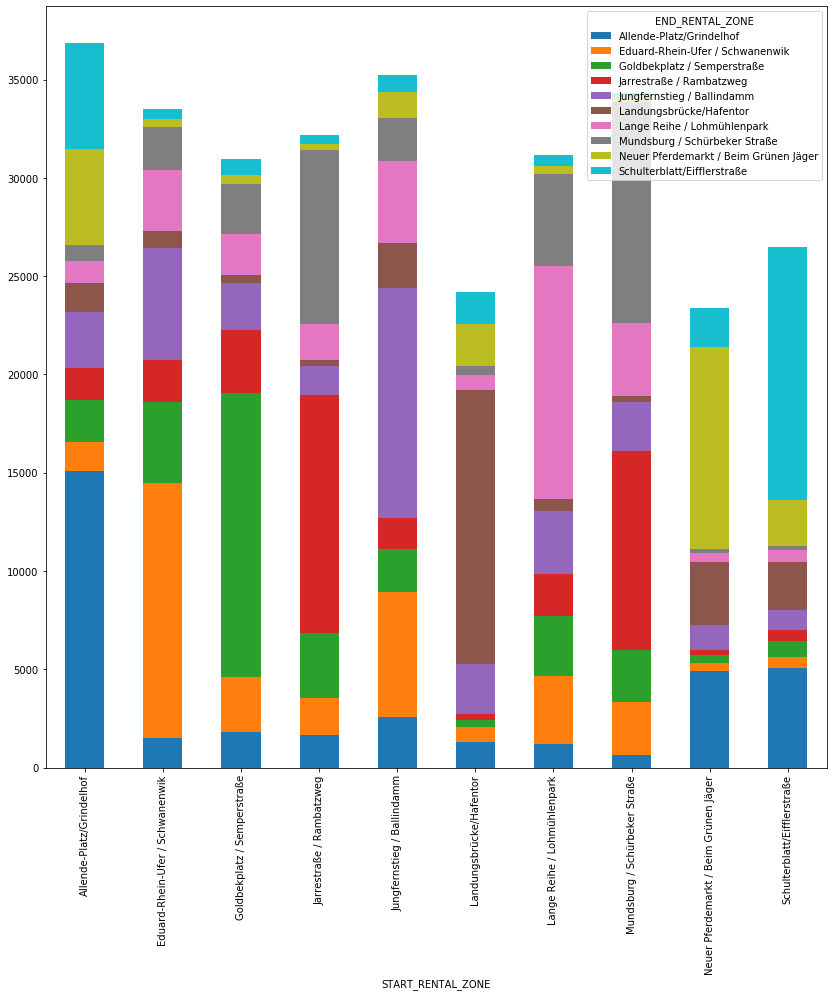

In [48]:
two_way_table.plot(kind="bar", 
                 figsize=(14,14),
                 stacked=True)

plt.savefig('../figs/two_way_table_bar_plot.png')

or as a heat map

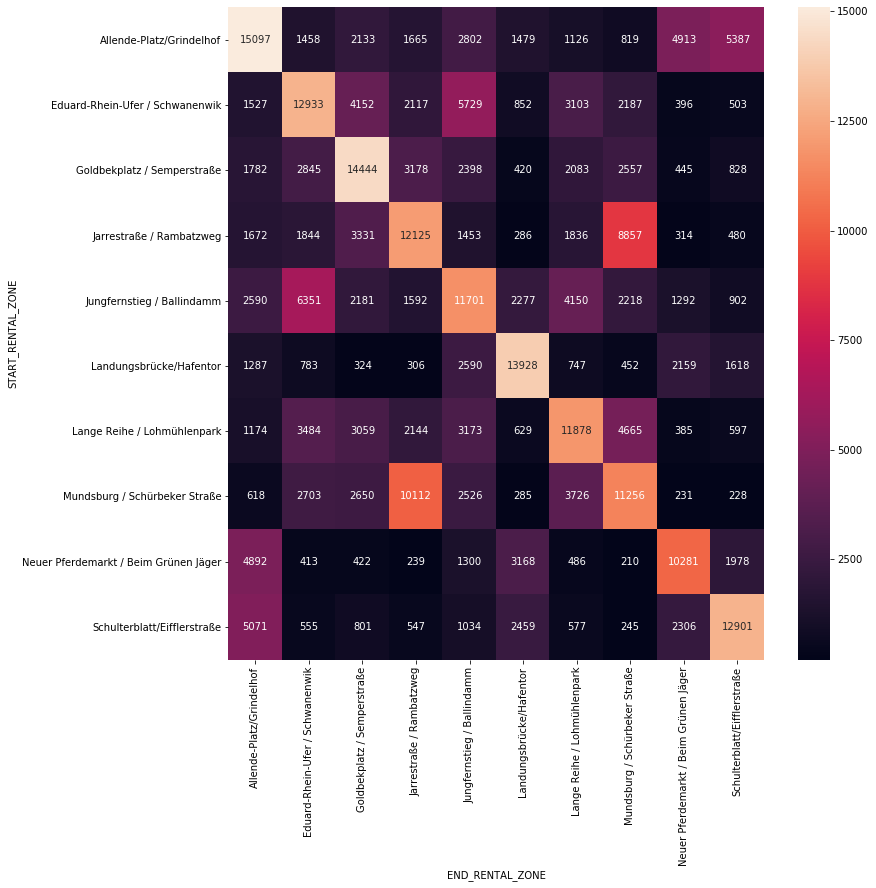

In [49]:
fig = plt.figure(figsize=(12,12))

plt.tight_layout()

sns.heatmap(two_way_table, annot=True, fmt='d')

plt.ylim(10,0)

plt.savefig('../figs/two_way_table.png')
plt.show()

split DATE_FROM into separate columns Date, Year, Month, Day, DayOfYear, Hour and minutes

In [50]:
data['Date'] = pd.to_datetime(data['DATE_FROM'].dt.date)
data['Year'] = data['DATE_FROM'].dt.year
data['Month'] = data['DATE_FROM'].dt.month
data['Day'] = data['DATE_FROM'].dt.day
data['DayOfYear'] = data['DATE_FROM'].dt.dayofyear   # the ordinal day of the year
data['DayOfWeek'] = data['DATE_FROM'].dt.dayofweek   # the ordinal day of the week (monday=0, sunday=6)
data['Time'] = data['DATE_FROM'].dt.hour + data['DATE_FROM'].dt.minute/60
data['Hour'] = data['DATE_FROM'].dt.hour
data['Minutes'] = data['DATE_FROM'].dt.minute

In [51]:
data.head()

CUSTOMER_HAL_ID           DATE_FROM  \
0  A821059B555C7764A2FF801180874A2FCB326222 2014-01-01 00:34:54   
1  1EBC930DB407ACEAE2FDE23A6CA40492EA3DFBB2 2014-01-01 01:39:55   
2  7AD2C1B70137479062A6DD73815835986677BB2D 2014-01-01 01:40:20   
3  A1062EF019B4E3E71C551572F1B284D55440E3C4 2014-01-01 01:56:00   
4  4F4F752203EA6FC872D576E9289C4E1B362E16F6 2014-01-01 02:05:55   

           DATE_UNTIL                    START_RENTAL_ZONE  \
0 2014-01-01 00:50:14                      U-Bahn Baumwall   
1 2014-01-01 01:57:27  Bahnhof Altona Ost/Max-Brauer-Allee   
2 2014-01-01 01:53:09          Weidestraße/Biedermannplatz   
3 2014-01-01 01:56:41      Große Bergstraße / Jessenstraße   
4 2014-01-01 02:13:49        Mundsburg / Schürbeker Straße   

                             END_RENTAL_ZONE       Date  Year  Month  Day  \
0             Mönckebergstraße / Rosenstraße 2014-01-01  2014      1    1   
1                Schulterblatt/Eifflerstraße 2014-01-01  2014      1    1   
2                   Jarrestraße / Rambatzweg 2014-01-01  2014      1    1   
3            Große Bergstraße / Jessenstraße 2014-01-01  2014      1    1   
4  Bartholomäusstraße/Beim Alten Schützenhof 2014-01-01  2014      1    1   

   DayOfYear  DayOfWeek      Time  Hour  Minutes  
0          1          2  0.566667     0       34  
1          1          2  1.650000     1       39  
2          1          2  1.666667     1       40  
3          1          2  1.933333     1       56  
4          1          2  2.083333     2        5

Obviously behaviour will be different on work days and on weekends or holidays. Let's encode that in the data.

We start by creating a calendar of public holidays in Hamburg

In [52]:
class HamburgHolidays(AbstractHolidayCalendar):
    rules = [Holiday('New Years Day', month=1, day=1),
             GoodFriday,
             EasterMonday,
             Holiday('First of May', month=5, day=1),
             Holiday('Ascension Day', month=1, day=1, offset=[Easter(), Day(39)]),
             Holiday('Pentecost', month=1, day=1, offset=[Easter(), Day(50)]),
             Holiday('German Unity Day', month=10,day=3),
             Holiday('Xmas 1', month=12,day=24),
             Holiday('Xmas 2', month=12,day=25),
             Holiday('Xmas 3', month=12,day=26),
             Holiday('New Years Eve', month=12,day=31)
             ]

cal = HamburgHolidays()

holidays = cal.holidays(start=data.Date.min(), end=pd.Timestamp(2020, 12, 31))

In [53]:
holidays

DatetimeIndex(['2014-01-01', '2014-04-18', '2014-04-21', '2014-05-01',
               '2014-05-29', '2014-06-09', '2014-10-03', '2014-12-24',
               '2014-12-25', '2014-12-26', '2014-12-31', '2015-01-01',
               '2015-04-03', '2015-04-06', '2015-05-01', '2015-05-14',
               '2015-05-25', '2015-10-03', '2015-12-24', '2015-12-25',
               '2015-12-26', '2015-12-31', '2016-01-01', '2016-03-25',
               '2016-03-28', '2016-05-01', '2016-05-05', '2016-05-16',
               '2016-10-03', '2016-12-24', '2016-12-25', '2016-12-26',
               '2016-12-31', '2017-01-01', '2017-04-14', '2017-04-17',
               '2017-05-01', '2017-05-25', '2017-06-05', '2017-10-03',
               '2017-12-24', '2017-12-25', '2017-12-26', '2017-12-31',
               '2018-01-01', '2018-03-30', '2018-04-02', '2018-05-01',
               '2018-05-10', '2018-05-21', '2018-10-03', '2018-12-24',
               '2018-12-25', '2018-12-26', '2018-12-31', '2019-01-01',
      

Let's add a new column to the data set denoting whether a particular day is a workday or not, i.e. is it a weekend or publich holiday or not?

In [54]:
data['Workingday'] = ((data['DayOfWeek'].isin([5, 6])==False) &
                       (data['Date'].isin(holidays)==False))

In [55]:
data.head()

CUSTOMER_HAL_ID           DATE_FROM  \
0  A821059B555C7764A2FF801180874A2FCB326222 2014-01-01 00:34:54   
1  1EBC930DB407ACEAE2FDE23A6CA40492EA3DFBB2 2014-01-01 01:39:55   
2  7AD2C1B70137479062A6DD73815835986677BB2D 2014-01-01 01:40:20   
3  A1062EF019B4E3E71C551572F1B284D55440E3C4 2014-01-01 01:56:00   
4  4F4F752203EA6FC872D576E9289C4E1B362E16F6 2014-01-01 02:05:55   

           DATE_UNTIL                    START_RENTAL_ZONE  \
0 2014-01-01 00:50:14                      U-Bahn Baumwall   
1 2014-01-01 01:57:27  Bahnhof Altona Ost/Max-Brauer-Allee   
2 2014-01-01 01:53:09          Weidestraße/Biedermannplatz   
3 2014-01-01 01:56:41      Große Bergstraße / Jessenstraße   
4 2014-01-01 02:13:49        Mundsburg / Schürbeker Straße   

                             END_RENTAL_ZONE       Date  Year  Month  Day  \
0             Mönckebergstraße / Rosenstraße 2014-01-01  2014      1    1   
1                Schulterblatt/Eifflerstraße 2014-01-01  2014      1    1   
2                   Jarrestraße / Rambatzweg 2014-01-01  2014      1    1   
3            Große Bergstraße / Jessenstraße 2014-01-01  2014      1    1   
4  Bartholomäusstraße/Beim Alten Schützenhof 2014-01-01  2014      1    1   

   DayOfYear  DayOfWeek      Time  Hour  Minutes  Workingday  
0          1          2  0.566667     0       34       False  
1          1          2  1.650000     1       39       False  
2          1          2  1.666667     1       40       False  
3          1          2  1.933333     1       56       False  
4          1          2  2.083333     2        5       False

How many booking per day of the week, by work day or not.

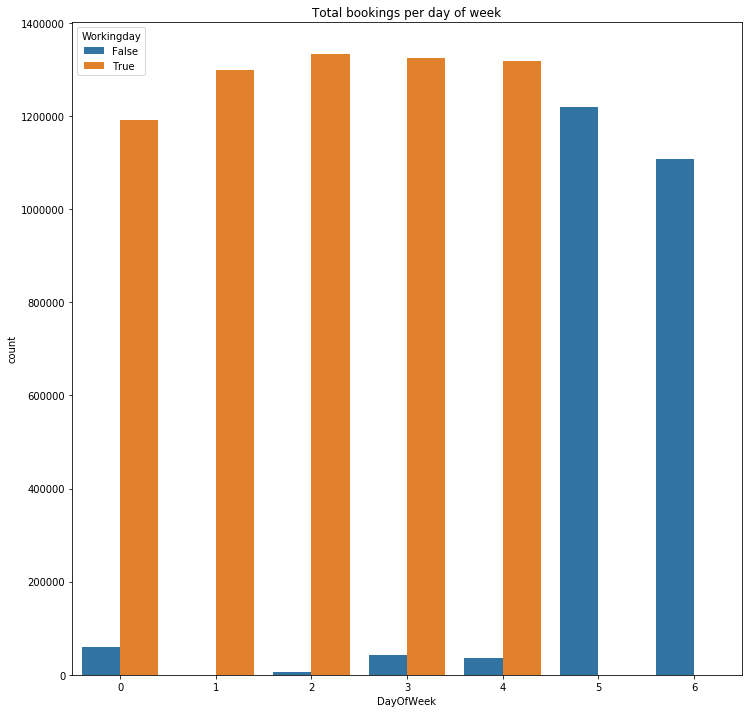

In [56]:
fig = plt.figure(figsize=(12,12))

plt.tight_layout()

sns.countplot(x="DayOfWeek", hue="Workingday", data=data)

plt.title('Total bookings per day of week')

plt.savefig('../figs/Bookings_day_of_week.png')
plt.show()

What does the distribution over a day look like, i.e. how many bookings per hour?

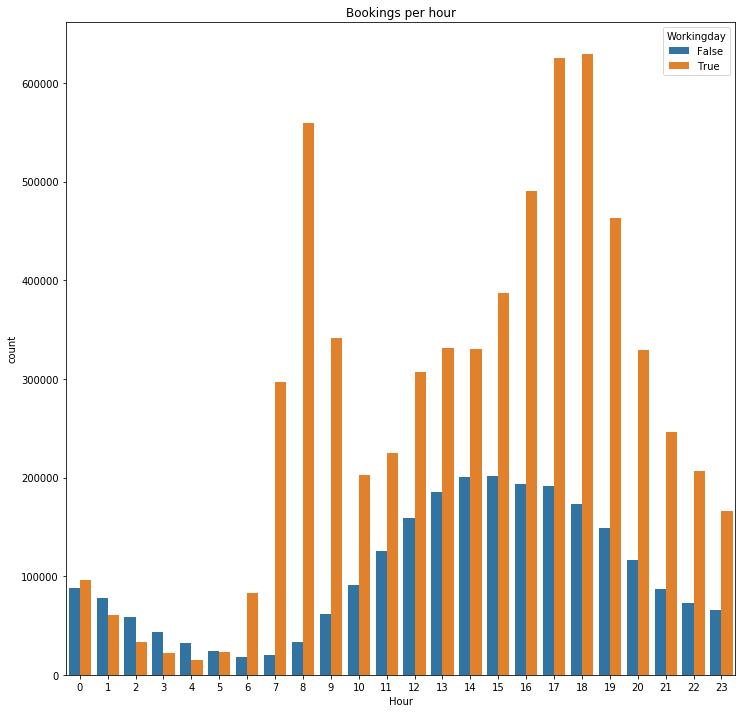

In [57]:
fig = plt.figure(figsize=(12,12))

plt.tight_layout()

sns.countplot(x="Hour", hue="Workingday", data=data)

plt.title('Bookings per hour')

plt.savefig('../figs/Bookings_by_hour.png')
plt.show()

We can observe clear differences between work day and holidays. On work days bikes seem to be rather popular during rush hour, on holidays and weekends rentals are much more distributed over the day.

What does the distribution over the months look like?

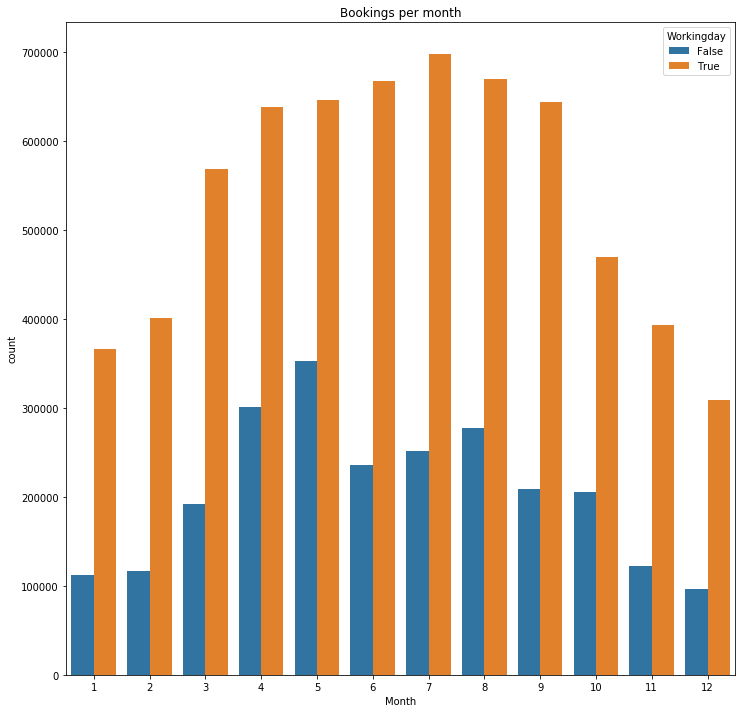

In [58]:
fig = plt.figure(figsize=(12,12))

plt.tight_layout()

sns.countplot(x="Month", hue="Workingday", data=data)

plt.title('Bookings per month')

plt.savefig('../figs/Bookings_by_month.png')
plt.show()

No real surprise here, bikes are rather less popular in the cold and rainy season.

Some more fun with feature engineering! Let's have a closer look at the lenghts of trips and also whether the bike was returned to the start zone or not.

In [59]:
data['booking_length'] = (data.DATE_UNTIL-data.DATE_FROM).astype('timedelta64[s]')

data['end_same_as_start'] = (data.START_RENTAL_ZONE == data.END_RENTAL_ZONE)

In [60]:
data.head()

CUSTOMER_HAL_ID           DATE_FROM  \
0  A821059B555C7764A2FF801180874A2FCB326222 2014-01-01 00:34:54   
1  1EBC930DB407ACEAE2FDE23A6CA40492EA3DFBB2 2014-01-01 01:39:55   
2  7AD2C1B70137479062A6DD73815835986677BB2D 2014-01-01 01:40:20   
3  A1062EF019B4E3E71C551572F1B284D55440E3C4 2014-01-01 01:56:00   
4  4F4F752203EA6FC872D576E9289C4E1B362E16F6 2014-01-01 02:05:55   

           DATE_UNTIL                    START_RENTAL_ZONE  \
0 2014-01-01 00:50:14                      U-Bahn Baumwall   
1 2014-01-01 01:57:27  Bahnhof Altona Ost/Max-Brauer-Allee   
2 2014-01-01 01:53:09          Weidestraße/Biedermannplatz   
3 2014-01-01 01:56:41      Große Bergstraße / Jessenstraße   
4 2014-01-01 02:13:49        Mundsburg / Schürbeker Straße   

                             END_RENTAL_ZONE       Date  Year  Month  Day  \
0             Mönckebergstraße / Rosenstraße 2014-01-01  2014      1    1   
1                Schulterblatt/Eifflerstraße 2014-01-01  2014      1    1   
2                   Jarrestraße / Rambatzweg 2014-01-01  2014      1    1   
3            Große Bergstraße / Jessenstraße 2014-01-01  2014      1    1   
4  Bartholomäusstraße/Beim Alten Schützenhof 2014-01-01  2014      1    1   

   DayOfYear  DayOfWeek      Time  Hour  Minutes  Workingday  booking_length  \
0          1          2  0.566667     0       34       False           920.0   
1          1          2  1.650000     1       39       False          1052.0   
2          1          2  1.666667     1       40       False           769.0   
3          1          2  1.933333     1       56       False            41.0   
4          1          2  2.083333     2        5       False           474.0   

   end_same_as_start  
0              False  
1              False  
2              False  
3               True  
4              False

a closer look a very short (less than five minutes) and very long (more than 12 hours) rentals

In [61]:
short_rentals = data[data.booking_length < 300]
long_rentals = data[data.booking_length > 43200]

In [62]:
short_rentals.shape

(1222729, 17)

In [63]:
long_rentals.shape

(18618, 17)

In [64]:
long_rentals.head()

CUSTOMER_HAL_ID           DATE_FROM  \
97    84106800EAFD1F171A0E9D1FBBAC1A08137B1D0C 2014-01-01 07:05:21   
1189  83098DDBC40A5CB615F551DBE35E6B4A8C11C79B 2014-01-01 02:48:25   
1963  CA6E1F49906FA5E94A113A8295BFA24143FFFA90 2014-01-01 16:55:40   
3508  C201815CEAF854A56AEA5CA1FFDE687A71C96597 2014-01-01 18:26:32   
4135  F7FA494A245F89697FAE76A32A265D22243E3801 2014-01-02 16:32:48   

              DATE_UNTIL                       START_RENTAL_ZONE  \
97   2014-01-02 12:55:46                   Wiesendamm/Roggenkamp   
1189 2014-01-04 07:13:40            Burgstraße/Hammer Landstraße   
1963 2014-01-02 17:44:18         Sternschanze / Eingang Dänenweg   
3508 2014-01-02 10:40:51              Lange Reihe / Kirchenallee   
4135 2014-01-03 20:47:38  Hauptbahnhof West / Glockengießer Wall   

                    END_RENTAL_ZONE       Date  Year  Month  Day  DayOfYear  \
97    Mundsburg / Schürbeker Straße 2014-01-01  2014      1    1          1   
1189   Burgstraße/Hammer Landstraße 2014-01-01  2014      1    1          1   
1963    Osakaallee/Übersee Quartier 2014-01-01  2014      1    1          1   
3508       Allende-Platz/Grindelhof 2014-01-01  2014      1    1          1   
4135             Leinpfad/Fernsicht 2014-01-02  2014      1    2          2   

      DayOfWeek       Time  Hour  Minutes  Workingday  booking_length  \
97            2   7.083333     7        5       False        107425.0   
1189          2   2.800000     2       48       False        275115.0   
1963          2  16.916667    16       55       False         89318.0   
3508          2  18.433333    18       26       False         58459.0   
4135          3  16.533333    16       32        True        101690.0   

      end_same_as_start  
97                False  
1189               True  
1963              False  
3508              False  
4135              False

The distribution of short rentals, according to whether the bike was returned to the start zone or not. 

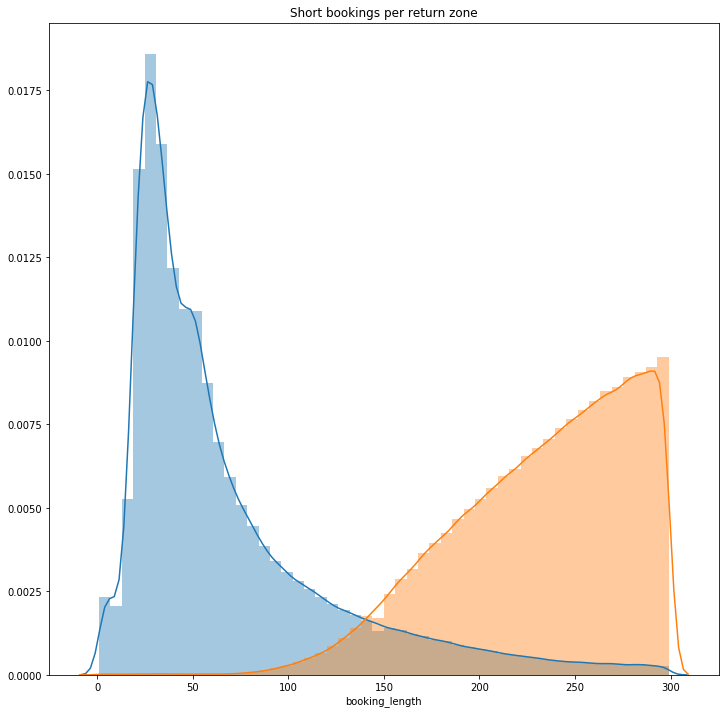

In [65]:
fig = plt.figure(figsize=(12,12))

plt.tight_layout()

sns.distplot(short_rentals[short_rentals.START_RENTAL_ZONE == short_rentals.END_RENTAL_ZONE]['booking_length'])
sns.distplot(short_rentals[short_rentals.START_RENTAL_ZONE != short_rentals.END_RENTAL_ZONE]['booking_length'])

plt.title('Short bookings per return zone')

plt.savefig('../figs/short_rentals.png')
plt.show()

Clearly, some customers changed their mind after having booked a bike and returned it to the start zone after a very short time. It is a rather small effect, but those ones will distort the analysis of destinations, i.e. we'll remove them shortly.

What do very long bookings look like?

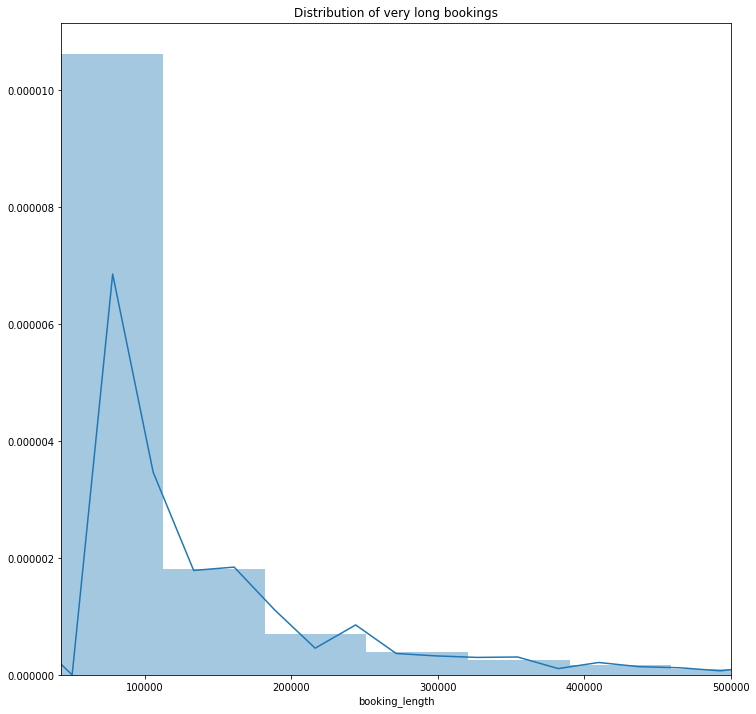

In [66]:
fig = plt.figure(figsize=(12,12))

plt.tight_layout()

sns.distplot(long_rentals['booking_length'])
plt.xlim(43200,500000)

plt.title('Distribution of very long bookings')

plt.savefig('../figs/long_bookings.png')
plt.show()

Clearly those should be investigated more closely. For now let's just drop those very short (less then 2 minutes) and very long (more than 12 hours) rentals.

In [67]:
data = data[ (data.booking_length > 120) & (data.booking_length < 43200)]

data.shape

(8463457, 17)

Distribution of booking lengths depending on whether it is working day or not.

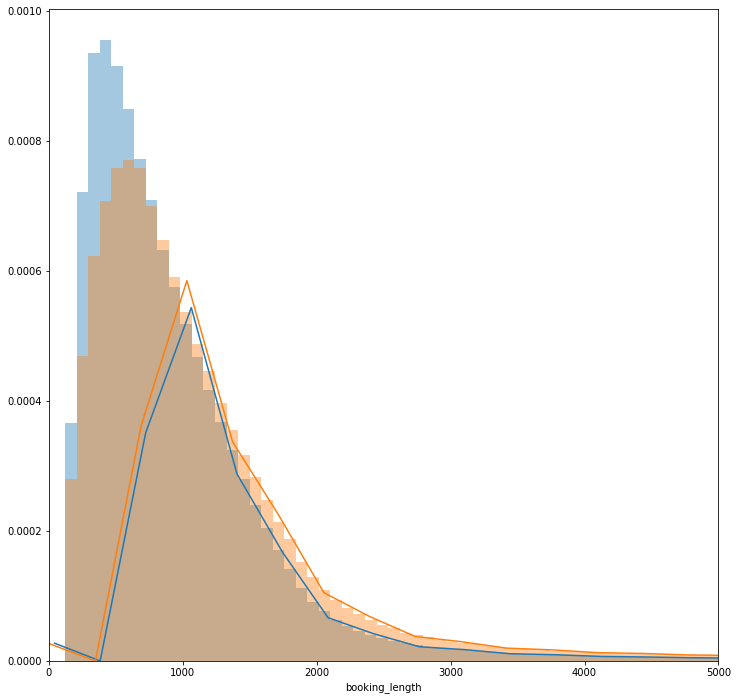

In [68]:
fig = plt.figure(figsize=(12,12))

plt.tight_layout()

sns.distplot(data[data.Workingday == True]['booking_length'], bins=500)
sns.distplot(data[data.Workingday == False]['booking_length'], bins=500)
plt.xlim(0,5000)

#plt.savefig('../figs/Bookings_by_month.png')
plt.show()

Distribution of booking lengths depending on whether the bike was returned to the start zone or not.

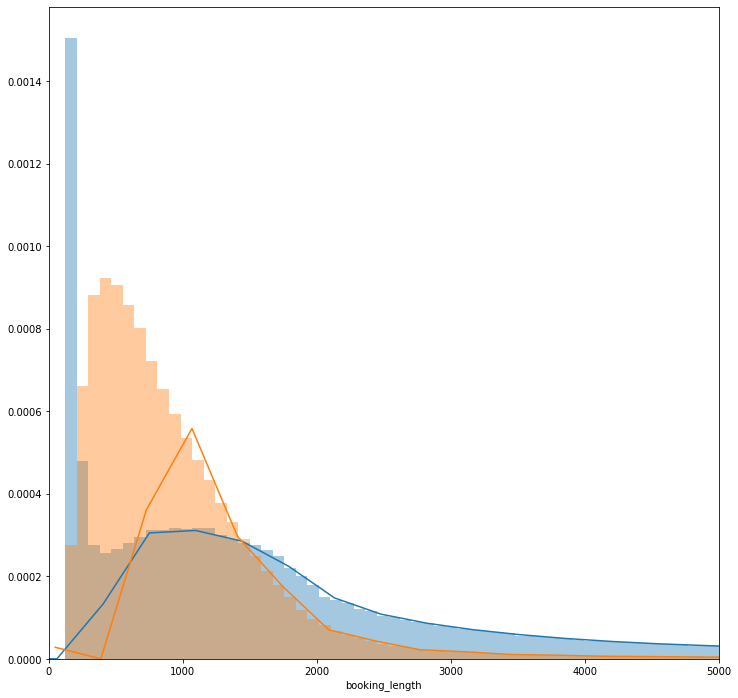

In [69]:
fig = plt.figure(figsize=(12,12))

plt.tight_layout()

sns.distplot(data[data.START_RENTAL_ZONE == data.END_RENTAL_ZONE]['booking_length'], bins=500)
sns.distplot(data[data.START_RENTAL_ZONE != data.END_RENTAL_ZONE]['booking_length'], bins=500)
plt.xlim(0,5000)

#plt.savefig('../figs/Bookings_by_month.png')
plt.show()

What kind of data are we left with? Having dropped so many rows, let's reset the index.

In [70]:
data.dtypes

CUSTOMER_HAL_ID              object
DATE_FROM            datetime64[ns]
DATE_UNTIL           datetime64[ns]
START_RENTAL_ZONE            object
END_RENTAL_ZONE              object
Date                 datetime64[ns]
Year                          int64
Month                         int64
Day                           int64
DayOfYear                     int64
DayOfWeek                     int64
Time                        float64
Hour                          int64
Minutes                       int64
Workingday                     bool
booking_length              float64
end_same_as_start              bool
dtype: object

In [71]:
data.tail()

CUSTOMER_HAL_ID           DATE_FROM  \
16228289  FF0963FE7D54E9455B5CF1ADE5DFEF484F8C525F 2017-05-16 01:11:33   
16228290  FF7147E7A3583564085352944933642F67C4D755 2017-05-16 03:25:09   
16228291  5BB54A7EBCD7A5A88FD410A537E10160BA120BB2 2017-05-16 07:15:40   
16228293  1024F6970D5BE146588D64F6AF427E147ADC642E 2017-05-16 07:36:36   
16228295  CC6405146B51242A9169AB55E88A5C472EA1B2AA 2017-05-16 07:40:17   

                  DATE_UNTIL                    START_RENTAL_ZONE  \
16228289 2017-05-16 01:32:16          Schulterblatt/Eifflerstraße   
16228290 2017-05-16 03:31:05        Königstraße / Struenseestraße   
16228291 2017-05-16 07:19:49                 Heußweg/Wiesenstraße   
16228293 2017-05-16 07:44:16  Bahnhof Altona Ost/Max-Brauer-Allee   
16228295 2017-05-16 07:50:07          Weidestraße/Biedermannplatz   

                                   END_RENTAL_ZONE       Date  Year  Month  \
16228289               Fischersallee/Bleickenallee 2017-05-16  2017      5   
16228290     Große Rainstraße/Ottenser Hauptstraße 2017-05-16  2017      5   
16228291  Lappenbergsallee / Bei der Apostelkirche 2017-05-16  2017      5   
16228293     Neuer Pferdemarkt / Beim Grünen Jäger 2017-05-16  2017      5   
16228295             Mundsburg / Schürbeker Straße 2017-05-16  2017      5   

          Day  DayOfYear  DayOfWeek      Time  Hour  Minutes  Workingday  \
16228289   16        136          1  1.183333     1       11        True   
16228290   16        136          1  3.416667     3       25        True   
16228291   16        136          1  7.250000     7       15        True   
16228293   16        136          1  7.600000     7       36        True   
16228295   16        136          1  7.666667     7       40        True   

          booking_length  end_same_as_start  
16228289          1243.0              False  
16228290           356.0              False  
16228291           249.0              False  
16228293           460.0              False  
16228295           590.0              False

In [72]:
data.reset_index(drop=True, inplace=True)

data.tail()

CUSTOMER_HAL_ID           DATE_FROM  \
8463452  FF0963FE7D54E9455B5CF1ADE5DFEF484F8C525F 2017-05-16 01:11:33   
8463453  FF7147E7A3583564085352944933642F67C4D755 2017-05-16 03:25:09   
8463454  5BB54A7EBCD7A5A88FD410A537E10160BA120BB2 2017-05-16 07:15:40   
8463455  1024F6970D5BE146588D64F6AF427E147ADC642E 2017-05-16 07:36:36   
8463456  CC6405146B51242A9169AB55E88A5C472EA1B2AA 2017-05-16 07:40:17   

                 DATE_UNTIL                    START_RENTAL_ZONE  \
8463452 2017-05-16 01:32:16          Schulterblatt/Eifflerstraße   
8463453 2017-05-16 03:31:05        Königstraße / Struenseestraße   
8463454 2017-05-16 07:19:49                 Heußweg/Wiesenstraße   
8463455 2017-05-16 07:44:16  Bahnhof Altona Ost/Max-Brauer-Allee   
8463456 2017-05-16 07:50:07          Weidestraße/Biedermannplatz   

                                  END_RENTAL_ZONE       Date  Year  Month  \
8463452               Fischersallee/Bleickenallee 2017-05-16  2017      5   
8463453     Große Rainstraße/Ottenser Hauptstraße 2017-05-16  2017      5   
8463454  Lappenbergsallee / Bei der Apostelkirche 2017-05-16  2017      5   
8463455     Neuer Pferdemarkt / Beim Grünen Jäger 2017-05-16  2017      5   
8463456             Mundsburg / Schürbeker Straße 2017-05-16  2017      5   

         Day  DayOfYear  DayOfWeek      Time  Hour  Minutes  Workingday  \
8463452   16        136          1  1.183333     1       11        True   
8463453   16        136          1  3.416667     3       25        True   
8463454   16        136          1  7.250000     7       15        True   
8463455   16        136          1  7.600000     7       36        True   
8463456   16        136          1  7.666667     7       40        True   

         booking_length  end_same_as_start  
8463452          1243.0              False  
8463453           356.0              False  
8463454           249.0              False  
8463455           460.0              False  
8463456           590.0              False

## Predicting the destination

Based on the data we'll endeavour to predict the three most likely destinations, i.e. the END_RENTAL_ZONE, for each booking.

If we were to just randomly pick three end zones out of the roughly 200 we have, the probability of hitting the correct answer would be 3/200, i.e. 1.5%. Any prediction that does better than that has succesfully found and utilized structure in the data.

As a first attempt we will predict the label, i.e. the END_RENTAL_ZONE, based on only two features, the START_RENTAL_ZONE and whether it's a working day or not.

In [73]:
label = ['END_RENTAL_ZONE']
features = ['START_RENTAL_ZONE', 
            #'Month', 
            #'Day', 
            #'DayOfYear', 
            #'Hour', 
            #'DayOfWeek', 
            'Workingday']

features+label

['START_RENTAL_ZONE', 'Workingday', 'END_RENTAL_ZONE']

Stratified 80/20 split of the data into a training and a test set

In [74]:
# for testing use only n most important stations

n = 10

most_important_stations = data.START_RENTAL_ZONE.value_counts()[:n].index.tolist()

data2 = data[data.START_RENTAL_ZONE.isin(most_important_stations) &
                               data.END_RENTAL_ZONE.isin(most_important_stations)]

train, test = train_test_split( data[features+label], test_size=0.2, random_state=0, stratify=data[features])

To reduce memory usage we'll encode the names of rental zones as an integer

In [75]:
label_encoder = LabelEncoder()

train['START_RENTAL_ZONE'] = label_encoder.fit_transform(train.START_RENTAL_ZONE)
train['END_RENTAL_ZONE'] = label_encoder.transform(train.END_RENTAL_ZONE)
test['START_RENTAL_ZONE'] = label_encoder.transform(test.START_RENTAL_ZONE)
test['END_RENTAL_ZONE'] = label_encoder.transform(test.END_RENTAL_ZONE)

In [76]:
train.shape

(6770765, 3)

In [77]:
test.shape

(1692692, 3)

The "machine learning model" we shall use is a very simple popularity based one. Simply counting the end zone associated with a start zone for each combination of features above tells us which are the most likely destinations.

In [78]:
# compute most popular destinations from training data

destination_popularity = train.groupby(features)\
                         .END_RENTAL_ZONE.value_counts().sort_values(ascending=False)

destination_popularity.head(10)

START_RENTAL_ZONE  Workingday  END_RENTAL_ZONE
17                 True        12                 13725
12                 True        17                 11200
168                True        170                10170
189                True        7                   9413
78                 True        195                 8846
170                True        168                 8843
112                True        7                   7935
129                True        50                  7629
79                 True        22                  7622
107                True        123                 7187
Name: END_RENTAL_ZONE, dtype: int64

dividing by the total number of occurences of START_RENTAL_ZONE gives the probability of each END_RENTAL_ZONE

In [79]:
destination_proba = destination_popularity.groupby(level=0).apply(lambda x:
                                                   x / float(x.sum()))

destination_proba.head(10)

START_RENTAL_ZONE  Workingday  END_RENTAL_ZONE
17                 True        12                 0.227220
12                 True        17                 0.178055
168                True        170                0.232649
189                True        7                  0.158585
78                 True        195                0.133982
170                True        168                0.178665
112                True        7                  0.087728
129                True        50                 0.113925
79                 True        22                 0.116120
107                True        123                0.153539
Name: END_RENTAL_ZONE, dtype: float64

a small function to get the n most probable destinations based on our set of features

In [80]:
def get_n_most_popular_dest(start_zone, workingday, n=3):
    # retrieve the n most popular destinations from the groupby object
    
    try:
        res = destination_proba[start_zone][workingday][:n].index.tolist()
    except:
        res = []
        
    return res

predict the 3 most likely destinations on the test set

In [81]:
n = 3

start = time.time()

test['Preds'] = test.apply(lambda x: get_n_most_popular_dest(x.START_RENTAL_ZONE,
                                             x.Workingday,
                                             n), axis=1)

end = time.time()

print('execution time in seconds:', end-start)

execution time in seconds: 1689.465815782547


In [82]:
test.head()

START_RENTAL_ZONE  Workingday  END_RENTAL_ZONE           Preds
8113333                 90        True              171  [84, 101, 137]
3961860                173        True               48  [156, 173, 88]
1185753                102        True              133   [102, 82, 66]
4735495                 50        True              183  [129, 124, 50]
2751982                107        True              191  [123, 107, 92]

to check the quality of the predictions we'll use Recall@n, i.e. in how many cases was the true destination in the list of n predicted destinations?

In [83]:

correct_preds = 0

start = time.time()

for index, row in test.iterrows():
    if row.END_RENTAL_ZONE in row.Preds:
        correct_preds += 1
    
end = time.time()

print('execution time in seconds:', end-start)

execution time in seconds: 384.26841711997986


In [84]:
recall_at_n = correct_preds/len(test)

print(recall_at_n)

0.21172546452632848


That's not too shabby for such a naive model. How can that be improved?
1. Use more of the features. However, the more granular the partitioning, the more likely we won't have data for any particular combination of features. Solution: use the above recommender as fall back option.
2. Personalized recommendations, i.e. use customer id in model
3. New features, e.g. geographical positions and distances between stations
4. Any remarkable destinations near to a rental station, e.g. tourist hotspots, airports, train stations, ..., any special events taking place?
5. Better models: surprise package contains all the standard recommender algorithms. Given that the majority of bike trips is rather short, i.e. to a close destination, I'd expect a neighborhoud based method (kNN) to perform rather well, once the distance between stations is included
6. Random Forest should also do rather well, but hyperparameter tuning can take a long time
7. Weather data? Long or leisure trips are less likely on rainy days

how would that work in practice?

new booking

In [85]:
new_booking = {'START_RENTAL_ZONE': 'Jungfernstieg / Ballindamm',
               'DATE_FROM': pd.to_datetime('now')}

new_booking

{'START_RENTAL_ZONE': 'Jungfernstieg / Ballindamm',
 'DATE_FROM': Timestamp('2020-03-04 09:55:43.048242')}

a small function to look up predicted destinations

In [86]:
def predict_destinations(message, n):
    
    Date = message['DATE_FROM'].date()
    DayOfWeek = message['DATE_FROM'].dayofweek
    start_zone = label_encoder.transform([message['START_RENTAL_ZONE']])[0]
    Workingday = (DayOfWeek in [5,6] == False) &\
                 (Date in holidays == False)
    pred = get_n_most_popular_dest(start_zone,
                                   Workingday,
                                   n)
    
    return label_encoder.inverse_transform(pred)


generate predictions for the new booking

In [87]:
predict_destinations(new_booking, 3)

array(['Eduard-Rhein-Ufer / Schwanenwik', 'Jungfernstieg / Ballindamm',
       'Lange Reihe / Lohmühlenpark'], dtype=object)

### Bonus content: first steps with Surprise

The approach shown above is very transparent but the performance is lackluster.

Let's see how Surpise performs when including some more features

In [88]:
label = ['END_RENTAL_ZONE']
features = ['START_RENTAL_ZONE', 
            'Month', 
            #'Day', 
            #'DayOfYear', 
            'Hour', 
            #'DayOfWeek', 
            'Workingday']

features+label

['START_RENTAL_ZONE', 'Month', 'Hour', 'Workingday', 'END_RENTAL_ZONE']

In [89]:
data[features+label].head()

START_RENTAL_ZONE  Month  Hour  Workingday  \
0                      U-Bahn Baumwall      1     0       False   
1  Bahnhof Altona Ost/Max-Brauer-Allee      1     1       False   
2          Weidestraße/Biedermannplatz      1     1       False   
3        Mundsburg / Schürbeker Straße      1     2       False   
4               Krausestraße/Eilbektal      1     2       False   

                             END_RENTAL_ZONE  
0             Mönckebergstraße / Rosenstraße  
1                Schulterblatt/Eifflerstraße  
2                   Jarrestraße / Rambatzweg  
3  Bartholomäusstraße/Beim Alten Schützenhof  
4     Lortzingstraße/Friedrichsberger Straße

In [90]:
'''
# for testing use only n most important stations

n = 10

most_important_stations = data.START_RENTAL_ZONE.value_counts()[:n].index.tolist()

data2 = data[data.START_RENTAL_ZONE.isin(most_important_stations) &
                               data.END_RENTAL_ZONE.isin(most_important_stations)]
'''

'\n# for testing use only n most important stations\n\nn = 10\n\nmost_important_stations = data.START_RENTAL_ZONE.value_counts()[:n].index.tolist()\n\ndata2 = data[data.START_RENTAL_ZONE.isin(most_important_stations) &\n                               data.END_RENTAL_ZONE.isin(most_important_stations)]\n'

again, encode zone names to reduce memory usage

In [91]:
label_encoder = LabelEncoder()

data['START_RENTAL_ZONE'] = label_encoder.fit_transform(data.START_RENTAL_ZONE)
data['END_RENTAL_ZONE'] = label_encoder.transform(data.END_RENTAL_ZONE)

Surpise expects a user, item, ratings dataframe as input.

In our case "user" would be the set of features, item the END_RENTAL_ZONE and rating how often it appears in connection with the set of features

In [92]:
# compute most popular destinations from training data

destination_popularity = data[features+label].groupby(features)\
                         .END_RENTAL_ZONE.value_counts().sort_values(ascending=False).reset_index(name='count')

destination_popularity.head(10)

START_RENTAL_ZONE  Month  Hour  Workingday  END_RENTAL_ZONE  count
0                112      5     8        True                7    458
1                189      5     8        True                7    447
2                112      4     8        True                7    440
3                189      4     8        True                7    432
4                189      6     8        True                7    429
5                112      3     8        True                7    423
6                112      9     8        True                7    411
7                132      3     8        True                7    406
8                189      9     8        True                7    404
9                189      7     8        True                7    402

In [93]:
destination_popularity.dtypes

START_RENTAL_ZONE    int64
Month                int64
Hour                 int64
Workingday            bool
END_RENTAL_ZONE      int64
count                int64
dtype: object

combine all features into one "user"

In [94]:
destination_popularity["input_feats"] = destination_popularity["START_RENTAL_ZONE"].astype(str) + '_' +\
                          destination_popularity["Month"].astype(str) +  '_' +\
                          destination_popularity["Hour"].astype(str) +  '_' +\
                          destination_popularity["Workingday"].astype(str)

destination_popularity.drop(labels=features, axis=1, inplace=True)

destination_popularity = destination_popularity[['input_feats', 'END_RENTAL_ZONE', 'count']]

destination_popularity.head()

input_feats  END_RENTAL_ZONE  count
0  112_5_8_True                7    458
1  189_5_8_True                7    447
2  112_4_8_True                7    440
3  189_4_8_True                7    432
4  189_6_8_True                7    429

we can pass the user, item, ratings dataframe to Surpise via it's Reader object.

important: the rating_scale has to be set, by default Surprise assumes that it is between 1 and 5 stars.

In [95]:
from surprise import Reader, Dataset
reader = Reader(rating_scale=(destination_popularity['count'].min(),destination_popularity['count'].max()))
surprise_data = Dataset.load_from_df(destination_popularity, reader)

split into train and test sets

In [96]:
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(surprise_data, test_size=0.2)

as an example let's test a matrix factorization approach, i.e. Singular Value Decomposition

train the model on the trainset

In [97]:
from surprise import SVD, accuracy
algo = SVD()
algo.fit(trainset)

generate predictions on the testset

In [98]:
predictions = algo.test(testset)

a helper function from the Surprise doumentation to get the n best recommendations

In [99]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

for each prediction get the top n recommendations

In [100]:
top_n = get_top_n(predictions, n=3)

a helper function from the Surprise documentation to compute recall@k

In [101]:
def recall_at_k(predictions, k=10, threshold=3.5):
    '''Return recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        #n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return recalls

what kind of recall@k do we get now'?

In [102]:
recalls = recall_at_k(predictions, k=3, threshold=1)

print(sum(rec for rec in recalls.values()) / len(recalls))

0.671804329273641
